<hr style="border:2px solid coral"></hr>

# Homework #7 (and possible project)

<hr style="border:2px solid coral"></hr>

For this last assignment, you are asked to parallelize one of two examples shown in class. 

1. The reaction-diffusion problem described in notebook 07_Parabolic_equations. 

2.  The advection problem described in notebook 08_Advection.

For either problem, run your code for at least $N=64$, and output enough files convincing show that your code works.   You should also run the code on at least 4 processors.  

For this homework, turn in a Jupyter noteobook showing the results of your code.  If you choose to develop your code outside of the notebook, be sure to submit all files necessary to run your code within the notebook.  That is, include any compile and commands necessary.




In [1]:
%%file hmwk07_all_2d.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
enum
{
    DIR_X = 0,
    DIR_Y
};

enum
{
    DIRICHLET=0,
    NEUMANN
};

enum
{
    LEFT=0,
    RIGHT,
    BOTTOM,
    TOP
};

int bc_type[4];

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

double u_true(double x,double y)
{
    return sin(2*x)*sin(2*y);
}

double ux_true(double x, double y)
{
    return 2*cos(2*x)*sin(2*y);
}

double uxx_true(double x, double y)
{
    return -4*u_true(x,y);
}

double uy_true(double x, double y)
{
    return 2*sin(2*x)*cos(2*y);
}

double uyy_true(double x, double y)
{
    return -4*u_true(x,y);
}

double un_true(int iside,double x,double y)
{
    double un;
    if (iside == LEFT)
        un = -ux_true(x,y);
    
    else if (iside == RIGHT)
        un = ux_true(x,y);
    
    else if (iside == BOTTOM)
        un = -uy_true(x,y);
    
    else if (iside == TOP)
        un = uy_true(x,y);

    return un;
}

double upp_true(double x,double y)
{
    return uxx_true(x,y) + uyy_true(x,y);
}

Overwriting hmwk07_all_2d.c


In [2]:
%%file hmwk07_parallel.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>
#include "hmwk07_all_2d.c"

double * write(int N,int N_local,double **q_local,int rank) //# gather file from all all processors
{
    double *Q = allocate_1d(N*N,0);
    double *q1 = allocate_1d(N_local*N_local,0);
      for (int j = 0; j<N_local; j++)
    {
        for (int k = 0; k < N_local; k++)
        {
            q1[N_local*j+k] = q_local[j][k];
            
        }
        
    }
    MPI_Gather(q1, N_local*N_local, MPI_DOUBLE, Q, N_local*N_local, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    
    free_1d(&q1,0);
    return Q;
}

void parallel_output(MPI_Comm comm_cart, int N, int Nx, int Ny, double **q, double *qbig)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int I,J;
    {
        int coords[2],ndims=2;
        MPI_Cart_coords(comm_cart,rank,ndims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
    }
    
    MPI_Comm sub_cart;
        
    // # Create a subgrid communicator.  Processors can only see those other procs that 
    // # remain in the subgrid.
    int remains[2] = {0,1}; // # Keep J in the communicator
    MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
    // # Step 1 : Gather over J on each I subgrid.
    double *cols_local = (J == 0) ? allocate_1d(Nx*N,0) : NULL;
    for(int i = 0; i < Nx; i++)
        MPI_Gather(q[i],Ny,MPI_DOUBLE,&cols_local[N*i],Ny,MPI_DOUBLE,0,sub_cart); 
                
    // # Get a communicator for J=0
    MPI_Comm I_comm;
    MPI_Comm_split(MPI_COMM_WORLD,J,rank,&I_comm);
        
    // # Step 2 : Gather across I, at procs corresponding to J=0
    if (J == 0)
        MPI_Gather(cols_local,Nx*N,MPI_DOUBLE,qbig,Nx*N,MPI_DOUBLE,0,I_comm);      
    
    free_1d(&cols_local,0);
}


void comm(int N, double **u, MPI_Comm comm_cart)
{
    int nbr[4];
    double *sendbuf = allocate_1d(N,0);
    double *recvbuf = allocate_1d(N,0);
    
    int maxdims = 1;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
     int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    
     
    
   // Fill left ghost cell
    {      
       
        int tag = 0;
        int disp = 1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[N-1][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[LEFT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[-1][j]  = recvbuf[j];       
    }     

   // Fill right ghost cell
    {    
        int tag = 1;
        
        int disp = -1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[0][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);


        if (nbr[RIGHT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[N][j]  = recvbuf[j];

    }

  // fill bottom ghost cell
    {
        int tag = 2;
        
        int disp = 1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][N-1];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[BOTTOM], &nbr[TOP]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[BOTTOM] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][-1]  = recvbuf[i];
    }

    // Fill top ghost cell
    {  
        int tag = 3;
        int disp = -1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][0];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[TOP], &nbr[BOTTOM]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[TOP] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][N]  = recvbuf[i];                

    }
    free_1d(&sendbuf,0);
    free_1d(&recvbuf,0);
}


void matvec(int N, double **q, double **L, MPI_Comm comm_cart)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    // # Get current coordinate in comm_cart
    int maxdims = 1;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    int I = coords[DIR_X];    
    int Imax = dims[DIR_X];
    
    int J = coords[DIR_Y];    
    int Jmax = dims[DIR_Y];
    
    int nbr[4];
    
    // # Get values at left : q[-1][j]
     
   
    
    if (I == 0)  
        for(int j = 0; j < N; j++)
        {
          if (bc_type[LEFT] == DIRICHLET)
                q[-1][j] = -q[0][j];
            else
                q[-1][j] = q[0][j];
        }
            
    
    // # Get values at right : q[N][j]
    if (I == Imax-1) 
        for(int j = 0; j < N; j++)
        {
          if (bc_type[RIGHT] == DIRICHLET)
                q[N][j] = -q[N-1][j]; 
            else
                 q[N][j] = q[N-1][j];  
        }
    
      
            
    // # Fill value at the bottom and top : q[i][-1], q[i][N]
    if (J == 0)  
        for(int i = 0; i < N; i++)
        {
          if (bc_type[BOTTOM] == DIRICHLET )
                q[i][-1] = -q[i][0];     
            else
               q[i][-1] = q[i][0];  
        }
            
    if (J == Jmax-1)  
        for(int i = 0; i < N; i++)
        {
          if (bc_type[TOP] == DIRICHLET )
                q[i][N] = -q[i][N-1];     
            else
                q[i][N] = q[i][N-1];  
        }
            
        // # Communicate internal boundary data
       comm(N, q, comm_cart);          
   
        
    // # Compute Laplacian (with homogenenous data)
    for(int i = 0; i < N; i++)    
        for(int j = 0; j < N; j++)
            {
              L[i][j] = q[i-1][j] + q[i+1][j] + q[i][j-1] + q[i][j+1] - 4*(q[i][j]); 
            }
     
}
 

int cg(int N, double **F, double **u, double tol, int kmax, int prt,MPI_Comm comm_cart)
{
    // # TODO : Implement at 2d CG solver
    
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    // # Get current coordinate in comm_cart
  
    

    int itcount = 0;
    int i1 =0;
    int i2 = N;
    
    double **uk = allocate_2d(N,N,0);
    double **pk = allocate_2d(N,N,1);    
    double **rk = allocate_2d(N,N,0);
    double **Apk = allocate_2d(N,N,0);
    double **rkp1 = allocate_2d(N,N,0);
    
  
    for(int i = i1; i < i2; i++)
     {
      for(int j = i1; j < i2; j++)
    {
        uk[i][j] = 0;
        rk[i][j] = F[i][j];
        //printf("rk[%d][%d] = %f\n", i,j,F[i][j]);
        pk[i][j] = rk[i][j];    // # Start with uk = 0 --> r = b - Au = b            
    }   
     }   
   
   
 
    for(int k = 0; k < kmax; k++)
    {
        
        matvec(N, pk, Apk, comm_cart);
        
        double rTr = 0;
        double pTAp = 0;
        double alocal[2];
        
        for(int i = i1; i < i2; i++)
        {
            for (int j = i1; j<i2;j++)
            {
            rTr += rk[i][j]*rk[i][j];
            pTAp += pk[i][j]*Apk[i][j]; 
            }
            
        }
        alocal[0] = rTr;
        alocal[1] = pTAp;
        
        
        
        double a_1[2];
        MPI_Allreduce(alocal,a_1,2,MPI_DOUBLE,MPI_SUM,MPI_COMM_WORLD);
        
        
        double alpha = a_1[0]/a_1[1];
      
        
        double rpTrp = 0;
        double max_res = 0;
        
        for(int i = i1; i < i2; i++)
        {
            for(int j = i1; j < i2; j++)
            {
                uk[i][j] = uk[i][j] + alpha*pk[i][j];
                rkp1[i][j] = rk[i][j] - alpha*Apk[i][j];
                rpTrp += rkp1[i][j]*rkp1[i][j];
                max_res = fmax(fabs(rkp1[i][j]),max_res);
            }
        }
        
        double b_local;
        
        MPI_Allreduce(&rpTrp,&b_local,1,MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD); 
    
        double error;
        MPI_Allreduce(&max_res,&error,1,MPI_DOUBLE,MPI_MAX,MPI_COMM_WORLD); 
        
        itcount = k+1;
        
        if (error < tol)
            break;
        
        
        double beta = b_local/a_1[0];
        
        for(int i = i1; i < i2; i++)
        {
         for(int j = i1; j < i2; j++)
            {
              pk[i][j] = rkp1[i][j] + beta*pk[i][j];   
            }
                  
        }
        
       
        for(int i = i1; i < i2; i++)
        {
         for (int j =i1; j<i2;j++)
               rk[i][j] = rkp1[i][j];  
        }
           
        
    }
    
    for(int i = i1; i < i2; i++)
    {
      for(int j = i1; j < i2; j++)
        {
          u[i][j] = uk[i][j];    
        }
             
    }
    
    
    
    free_2d(&uk,0);
    free_2d(&pk,1);
    free_2d(&rk,0);
    free_2d(&rkp1,0);
    free_2d(&Apk,0);

    
    
    return itcount;
    
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    int N;
    int ndim = 2;
    int dims[ndim];
    if (argc > 3)
    {
        // # Number of processors in each direction.  Product should equal nprocs.
        dims[DIR_X] = atoi(argv[1]);
        dims[DIR_Y] = atoi(argv[2]);
        
    }
    

    N = atoi(argv[3]);    
    for(int i = 0; i < 4; i++)
        bc_type[i] = atoi(argv[4+i]);
       

    if (rank == root)
        if (dims[DIR_X]*dims[DIR_Y] !=nprocs)
        {
            printf("dim[0]*dim[1] != nprocs\n");
            exit(0);
        }

    // # Domain
    double a = 0, b = 2*M_PI;
    
    // # Numerical parameters
    double tol = 1e-13;
    int kmax = 10000;    
    int prt = 0;
   
    MPI_Comm comm_cart;
    int periodicity[2] = {0,0};
    int reorder = 0;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);

    // # Get coordinate of current rank
    int I, J, coords[ndim];
    {
        int maxdims = 2;
        MPI_Cart_coords(comm_cart,rank,maxdims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
        
    }
    
    // # Create domain  [0,P]x[0,1], where P=nprocs
    int P = nprocs;
   
    // # Set grid values
       
    // Assume Nx = Ny
    int Nx = N/dims[DIR_X];
    
    double dw = (b-a)/dims[DIR_X];
    double a_local_x = a + I*dw;
       
    double a_local_y = a + J*dw;

    double h = (b - a)/N;
            
    
    
     
    // # Set grid values and a true solution
    int N_local =Nx;
    // # Arrays    
    double **u_local = allocate_2d(N_local,N_local,1);
    double **F_local = allocate_2d(N_local,N_local,0);
    double *x_local = allocate_1d(N_local,0);
    double *y_local = allocate_1d(N_local,0);
    
    // # Initialization
    for(int i = 0; i < N_local; i++)
    {
        x_local[i] = a_local_x + (i+0.5)*h;
      
        for(int j = 0; j < N_local; j++)
        {  
            y_local[j] = a_local_y + (j+0.5)*h;
    
            F_local[i][j] = pow(h,2)*upp_true(x_local[i],y_local[j]);
        }
    }
    
    int Imax = dims[DIR_X];
    int Jmax = dims[DIR_Y];
    
    for(int i = 0; i < N_local; i++)
    {
        if (I == 0  )
            {
            if (bc_type[LEFT] == DIRICHLET)
                F_local[0][i] -=  2* u_true(a_local_x,y_local[i]);  
            else
                F_local[0][i] -=h*un_true(LEFT,a, y_local[i]);
                
            }
        
        if (I == Imax-1  )
        {
           if (bc_type[RIGHT] == DIRICHLET)
                F_local[N_local-1][i] -=2*u_true(b,y_local[i]);   
            else
                F_local[N_local-1][i] -=h*un_true(RIGHT,b, y_local[i]); 
        }
            
        
        if (J == 0)
        {
            if (bc_type[BOTTOM] == DIRICHLET)
            {
              F_local[i][0] -=2*u_true(x_local[i],a); 
            }
                
            else
                F_local[i][0] -=h*un_true(BOTTOM,x_local[i],a);
            
        }
            
        
        if (J == Jmax-1)
        {
          if (bc_type[TOP] == DIRICHLET)
            {
              F_local[i][N_local-1] -=2*u_true(x_local[i],b);
                
            }
                
            else
                F_local[i][N_local-1] -=h*un_true(TOP,x_local[i],b);   
        }
              
    }
    int itcount = cg(N_local,F_local,u_local,tol,kmax,prt,comm_cart);
    if (rank == 0)
        printf("iteration count = %d\n", itcount);
    
      
    double max_err = 0;
       for(int i = 0; i < N_local; i++)
    {
        for(int j = 0; j<N_local; j++)
        {
            max_err = fmax(fabs(u_true(x_local[i],y_local[j]) - u_local[i][j]),max_err);
        }
   
         
    } 
    
    
    double MAXERR;
    MPI_Reduce(&max_err, &MAXERR, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD); 
   
    
    if (rank == 0)
        printf("Error (pde): %12.4e\n", MAXERR);
    
    if (rank == 0)
    {
         FILE* fout = fopen("err_07.dat","w");   
         fwrite(&MAXERR,sizeof(double),1,fout);
         fwrite(&itcount,sizeof(int),1,fout);
         fclose(fout);
    }
    
    FILE *file; 
    double *qbig = NULL;
    if (rank == 0)
    {           
        file = fopen("hm7_07.dat","wb");  
        fwrite(&N,sizeof(int),1,file);
        fwrite(bc_type,sizeof(int),4,file);
        fwrite(&a,sizeof(double),1,file);
        fwrite(&b,sizeof(double),1,file);
        qbig  = allocate_1d(N*N,0); 
    } 
    
     // # Use parallel output routine above to gather solution to qbig on rank 0
    parallel_output(comm_cart,N,N_local,N_local,u_local,qbig);
    
    // # Write out the big array
    if (rank == 0)
    {
        fwrite(qbig,sizeof(double),N*N,file);             
        fclose(file);            
        free_1d(&qbig,0);        
    }

    free_1d(&x_local,0);
    free_1d(&y_local,0);
    free_2d(&F_local,0);
    free_2d(&u_local,1);
    
    MPI_Finalize();
    return 0;
}

Overwriting hmwk07_parallel.c


In [3]:
%%bash 

mpicc -o hmwk07_parallel hmwk07_parallel.c

# mpirun -n <nprocs> cart_03 <dim[0]> <dim[1]>
# where dim[0]*dim[1] = nprocs

mpirun -n 4 ./hmwk07_parallel 2 2 64 1 1 0 0

iteration count = 46
Error (pde):   3.5574e-03


In [4]:
import os
from matplotlib.pyplot import *
from numpy import *

In [5]:
from enum import Enum

In [6]:

fout = open("hm7_07.dat","rb")
N, = fromfile(fout,dtype=int32,count=1)
fout.close()

In [7]:
dt = dtype([('N',int32),\
            ('bc_type',int32,4), \
            ('a',float64), \
            ('b',float64),\
            ('u',float64,N*N)])



fout = open("hm7_07.dat","rb")
N,bc,a,b,u = fromfile(fout,dtype=dt, count=1)[0]
fout.close()

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)
bc_type = [bc_types(bc[i]) for i in range(4)]

print(f"{N=:d} {a=:f} {b=:f}")
print(f"Left   : {bc_type[0]:s}")
print(f"Right  : {bc_type[1]:s}")
print(f"Bottom : {bc_type[2]:s}")
print(f"Top    : {bc_type[3]:s}")

N=64 a=0.000000 b=6.283185
Left   : bc_types.NEUMANN
Right  : bc_types.NEUMANN
Bottom : bc_types.DIRICHLET
Top    : bc_types.DIRICHLET


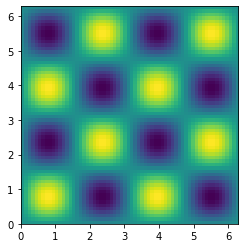

In [8]:
clf()
figure(1)

u = reshape(u,(N,N))

imshow(u,extent=[a,b,a,b],origin='lower');

In [9]:
import subprocess
import shlex

#assert 1==0, "Code not yet implemented"

print(f"{a=:f} {b=:f}")
print(f"Left   : {bc_type[0]:s}")
print(f"Right  : {bc_type[1]:s}")
print(f"Bottom : {bc_type[2]:s}")
print(f"Top    : {bc_type[3]:s}")
print("")

# Run command
bc_str = ' '.join([f"{bc_type[i].value:d}" for i in range(4)])
shell_cmd = 'mpirun -n 4 ./hmwk07_parallel 2 2 {N:d} {bc_str:s}'.format

M = 8
N0 = 8
Nv = N0*2**arange(M)

dt1 = dtype([('err',float64),('itcount',int32)])

err = empty(M)
for i in range(M):
    N = Nv[i]
    cmd = shell_cmd(N=N,bc_str=bc_str)
    arg_list = shlex.split(cmd) 

    # Run output
    output=subprocess.run(arg_list,capture_output=True)
    if (rc := output.returncode) != 0:
        print(f"Return code = {rc:d} : Invalid boundary condition choice")
        break
        
    fout = open("err_07.dat","rb")
    err_pde,itcount = fromfile(fout,dtype=dt1, count=1)[0]
    fout.close()
        
    err[i] = err_pde
    
    print(f"{N:5d} {err_pde:12.4e} {itcount:8d} ",end="")    
    if i > 0:
        rate2 = (err[i-1]/err[i])
        print(f"{rate2:8.4f} {log2(rate2):8.4f}")
    else:
        print("{:>8s}".format("---"))

print("")
print('Done.')        

a=0.000000 b=6.283185
Left   : bc_types.NEUMANN
Right  : bc_types.NEUMANN
Bottom : bc_types.DIRICHLET
Top    : bc_types.DIRICHLET

    8   1.6186e-01        4      ---
   16   5.3345e-02        8   3.0342   1.6013
   32   1.4098e-02       20   3.7839   1.9199
   64   3.5574e-03       46   3.9630   1.9866
  128   8.9071e-04       96   3.9939   1.9978
  256   2.2285e-04      191   3.9969   1.9989
  512   5.5718e-05      377   3.9996   1.9999
 1024   1.3930e-05      745   3.9998   1.9999

Done.


## Problem 2

In [10]:
%%file RD_all_2d.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

enum
{
    DIRICHLET=0,
    NEUMANN
};

enum
{
    LEFT=0,
    RIGHT,
    BOTTOM,
    TOP
};

enum
{
    DIR_X = 0,
    DIR_Y
};

int bc_type[4];

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

Overwriting RD_all_2d.c


In [11]:
%%file cg_serial_fix.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>
#include "RD_all_2d.c"

void parallel_output(MPI_Comm comm_cart, int N, int Nx, int Ny, double **q, double *qbig)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int I,J;
    {
        int coords[2],ndims=2;
        MPI_Cart_coords(comm_cart,rank,ndims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
    }
    
    MPI_Comm sub_cart;
        
    // # Create a subgrid communicator.  Processors can only see those other procs that 
    // # remain in the subgrid.
    int remains[2] = {0,1}; // # Keep J in the communicator
    MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
    // # Step 1 : Gather over J on each I subgrid.
    double *cols_local = (J == 0) ? allocate_1d(Nx*N,0) : NULL;
    for(int i = 0; i < Nx; i++)
        MPI_Gather(q[i],Ny,MPI_DOUBLE,&cols_local[N*i],Ny,MPI_DOUBLE,0,sub_cart); 
                
    // # Get a communicator for J=0
    MPI_Comm I_comm;
    MPI_Comm_split(MPI_COMM_WORLD,J,rank,&I_comm);
        
    // # Step 2 : Gather across I, at procs corresponding to J=0
    if (J == 0)
        MPI_Gather(cols_local,Nx*N,MPI_DOUBLE,qbig,Nx*N,MPI_DOUBLE,0,I_comm);      
    
    free_1d(&cols_local,0);
}


void comm(int N, double **u, MPI_Comm comm_cart)
{
    int nbr[4];
    double *sendbuf = allocate_1d(N,0);
    double *recvbuf = allocate_1d(N,0);
    
    int maxdims = 2;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
     int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    
     
    
   // Fill left ghost cell
    {      
       
        int tag = 0;
        int disp = 1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[N-1][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[LEFT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[-1][j]  = recvbuf[j];       
    }     

   // Fill right ghost cell
    {    
        int tag = 1;
        
        int disp = -1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[0][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);


        if (nbr[RIGHT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[N][j]  = recvbuf[j];

    }

  // fill bottom ghost cell
    {
        int tag = 2;
        
        int disp = 1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][N-1];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[BOTTOM], &nbr[TOP]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[BOTTOM] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][-1]  = recvbuf[i];
    }

    // Fill top ghost cell
    {  
        int tag = 3;
        int disp = -1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][0];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[TOP], &nbr[BOTTOM]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[TOP] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][N]  = recvbuf[i];                

    }
    free_1d(&sendbuf,0);
    free_1d(&recvbuf,0);
}



void matvec(int N, double **q, double **L,double lambda, MPI_Comm comm_cart)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    // # Get current coordinate in comm_cart
    int maxdims = 1;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    int I = coords[DIR_X];    
    int Imax = dims[DIR_X];
    
    int J = coords[DIR_Y];    
    int Jmax = dims[DIR_Y];
    
    int nbr[4];
    
    // # Get values at left : q[-1][j]
     
   
    
    if (I == 0)  
        for(int j = 0; j < N; j++)
        {
          if (bc_type[LEFT] == DIRICHLET)
                q[-1][j] = -q[0][j];
            else
                q[-1][j] = q[0][j];
        }
            
    
    // # Get values at right : q[N][j]
    if (I == Imax-1) 
        for(int j = 0; j < N; j++)
        {
          if (bc_type[RIGHT] == DIRICHLET)
                q[N][j] = -q[N-1][j]; 
            else
                 q[N][j] = q[N-1][j];  
        }
    
      
            
    // # Fill value at the bottom and top : q[i][-1], q[i][N]
    if (J == 0)  
        for(int i = 0; i < N; i++)
        {
          if (bc_type[BOTTOM] == DIRICHLET )
                q[i][-1] = -q[i][0];     
            else
               q[i][-1] = q[i][0];  
        }
            
    if (J == Jmax-1)  
        for(int i = 0; i < N; i++)
        {
          if (bc_type[TOP] == DIRICHLET )
                q[i][N] = -q[i][N-1];     
            else
                q[i][N] = q[i][N-1];  
        }
            
        // # Communicate internal boundary data
       comm(N, q, comm_cart);          
   
        
    // # Compute Laplacian (with homogenenous data)
    for(int i = 0; i < N; i++)    
        for(int j = 0; j < N; j++)
            {
              L[i][j] = q[i-1][j] + q[i+1][j] + q[i][j-1] + q[i][j+1] - 4*(q[i][j]); 
              L[i][j] -= lambda*q[i][j];
            }
     
}
 

int cg(int N, double **F, double **u, double tol, int kmax, int prt,double lambda,MPI_Comm comm_cart)
{
    // # TODO : Implement at 2d CG solver
    
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    // # Get current coordinate in comm_cart
  
    

    int itcount = 0;
    int i1 =0;
    int i2 = N;
    
    double **uk = allocate_2d(N,N,0);
    double **pk = allocate_2d(N,N,1);    
    double **rk = allocate_2d(N,N,0);
    double **Apk = allocate_2d(N,N,0);
    double **rkp1 = allocate_2d(N,N,0);
    
  
    for(int i = i1; i < i2; i++)
     {
      for(int j = i1; j < i2; j++)
    {
        uk[i][j] = 0;
        rk[i][j] = F[i][j];
        //printf("rk[%d][%d] = %f\n", i,j,F[i][j]);
        pk[i][j] = rk[i][j];    // # Start with uk = 0 --> r = b - Au = b            
    }   
     }   
   
   
 
    for(int k = 0; k < kmax; k++)
    {
        
        matvec(N, pk, Apk,lambda, comm_cart);
        
        double rTr = 0;
        double pTAp = 0;
        double alocal[2];
        
        for(int i = i1; i < i2; i++)
        {
            for (int j = i1; j<i2;j++)
            {
            rTr += rk[i][j]*rk[i][j];
            pTAp += pk[i][j]*Apk[i][j]; 
            }
            
        }
        alocal[0] = rTr;
        alocal[1] = pTAp;
        
        
        
        double a_1[2];
        MPI_Allreduce(alocal,a_1,2,MPI_DOUBLE,MPI_SUM,MPI_COMM_WORLD);
        
        
        double alpha = a_1[0]/a_1[1];
      
        
        double rpTrp = 0;
        double max_res = 0;
        
        for(int i = i1; i < i2; i++)
        {
            for(int j = i1; j < i2; j++)
            {
                uk[i][j] = uk[i][j] + alpha*pk[i][j];
                rkp1[i][j] = rk[i][j] - alpha*Apk[i][j];
                rpTrp += rkp1[i][j]*rkp1[i][j];
                max_res = fmax(fabs(rkp1[i][j]),max_res);
            }
        }
        
        double b_local;
        
        MPI_Allreduce(&rpTrp,&b_local,1,MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD); 
    
        double error;
        MPI_Allreduce(&max_res,&error,1,MPI_DOUBLE,MPI_MAX,MPI_COMM_WORLD); 
        
        itcount = k+1;
        
        if (error < tol)
            break;
        
        
        double beta = b_local/a_1[0];
        
        for(int i = i1; i < i2; i++)
        {
         for(int j = i1; j < i2; j++)
            {
              pk[i][j] = rkp1[i][j] + beta*pk[i][j];   
            }
                  
        }
        
       
        for(int i = i1; i < i2; i++)
        {
         for (int j =i1; j<i2;j++)
               rk[i][j] = rkp1[i][j];  
        }
           
        
    }
    
    for(int i = i1; i < i2; i++)
    {
      for(int j = i1; j < i2; j++)
        {
          u[i][j] = uk[i][j];    
        }
             
    }
    
    free_2d(&uk,0);
    free_2d(&pk,1);
    free_2d(&rk,0);
    free_2d(&rkp1,0);
    free_2d(&Apk,0);

    
    
    return itcount;
    
}


Overwriting cg_serial_fix.c


In [12]:
%matplotlib notebook

from numpy import *
from matplotlib.pyplot import *

In [13]:
%%file spiral_parallel.c

#include <stdio.h>
#include <stdlib.h>

#include <math.h>

#include "cg_serial_fix.c"

double * write(int N,int N_local,double **q_local,int rank) //# gather file from all all processors
{
    double *Q = allocate_1d(N*N,0);
    double *q1 = allocate_1d(N_local*N_local,0);
      for (int j = 0; j<N_local; j++)
    {
        for (int k = 0; k < N_local; k++)
        {
            q1[N_local*j+k] = q_local[j][k];
            
        }
        
    }
    MPI_Gather(q1, N_local*N_local, MPI_DOUBLE, Q, N_local*N_local, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    free_1d(&q1,0);
    return Q;
}


int main(int argc, char** argv)
{
    FILE *fout = fopen("spiral_parallel.dat","w");
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int root = 0;
    int ndim = 2;
    int dims[ndim];
    if (argc > 3)
    {
        // # Number of processors in each direction.  Product should equal nprocs.
        dims[DIR_X] = atoi(argv[1]);
        dims[DIR_Y] = atoi(argv[2]);
        
    }
    else
    {
        printf("mpirun 4 spiral 2 2 <N> <nout> <Tfinal>\n");
        exit(0);  
    }
    
    int N, nout;
    double Tfinal;
    
    N = atoi(argv[3]);
    nout = atoi(argv[4]);  //# Number of time steps
    Tfinal = atof(argv[5]);
    
    
    for(int i = 0; i < 4; i++)
        bc_type[i] = NEUMANN;
    
    


    // Model parameters 
    double a_model = 0.75;
    double b_model = 0.01;
    double e_model = 0.02;

    // --------------------------- Numerical parameters -------------------------------

    int kmax = 1000;
    double tol = 1e-12;
    int prt = 0;
    // ---------------------------- Initialize solution -------------------------------
    
    if (rank == root)
        if (dims[DIR_X]*dims[DIR_Y] !=nprocs)
        {
            printf("dim[0]*dim[1] != nprocs\n");
            exit(0);
        }

    MPI_Comm comm_cart;
    int periodicity[2] = {0,0};
    int reorder = 0;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);

    // # Get coordinate of current rank
    int I, J, coords[ndim];
    {
        int maxdims = 2;
        MPI_Cart_coords(comm_cart,rank,maxdims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
        
    }
   
    // # Set grid values
       
    // Assume Nx = Ny
    int Nx = N/dims[DIR_X];
    
    double L = 20;
    double a = -L, b = L;
    
    double dw = (b-a)/dims[DIR_X];
    double a_local_x = a + I*dw;
       
    double a_local_y = a + J*dw;

    double h = (b - a)/N;
    
    // # Set grid values and a true solution
    int N_local =Nx;
    // # Arrays 
    double **u = allocate_2d(N_local,N_local,1);
    double **v = allocate_2d(N_local,N_local,1);

    for(int i = -1; i < N_local+1; i++)
    {
        double x = a_local_x + (i+0.5)*h;
        for(int j = -1; j < N_local+1; j++)
        {
            double y = a_local_y + (j+0.5)*h;
            u[i][j] = (y > 0) ? 1 : 0;           
            v[i][j] = (x > 0) ? 1 : 0;
        }
    }
    

    
    // ----------------------------- Compute time step ---------------------------------
    // # Compute a stable time step
    // # 1.  Estimate a stable time step 'dt_stable'.   This may not evenly divide Tfinal. 
    // # 2.  Compute a minimum number M of time steps we need to take.
    // # 3.  Divide Tfinal by M to get get a dt that is guaranteed smaller than dt_est and  
    // #     satisfies M*dt = Tfinal.

        
    double dt_est = h/30;
    
    
    double dT = Tfinal/nout;
    int M_inner = ceil(dT/dt_est) + 1;   // # Compute M to guarantee we hit Tfinal
    double dt = dT/M_inner;
    int M = nout*M_inner;
    
    if (rank == 0)
        printf("dt = %f\n",dt);
    
    // # Time stepping
    double **up = allocate_2d(N_local,N_local,1);
    double **vp = allocate_2d(N_local,N_local,1);
    
    double t = 0;
    int Frame = 0;
    
    double *qbigU = NULL;
    double *qbigV = NULL;
    
    if (rank == 0)
    {
        printf("Frame %5d (step %5d)  t = %8.4f (itcount = %d)\n",Frame,0,t,0);       
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&nout,1,sizeof(int),fout);
        fwrite(&a,1,sizeof(double),fout);
        fwrite(&b,1,sizeof(double),fout);
        fwrite(&t,1,sizeof(double),fout);    
        
        qbigU  = allocate_1d(N*N,0); 
        qbigV = allocate_1d(N*N,0); 
        
    }
    
    // # Use parallel output routine above to gather solution to qbig on rank 0
    parallel_output(comm_cart,N,N_local,N_local,u,qbigU);
    parallel_output(comm_cart,N,N_local,N_local,v,qbigV);
    
    // # Write out the big array
    if (rank == 0)
    {
        fwrite(qbigU,sizeof(double),N*N,fout); 
        fwrite(qbigV,sizeof(double),N*N,fout);       
        free_1d(&qbigU,0);
        free_1d(&qbigV,0);
    }

    
    double **F = allocate_2d(N_local,N_local,0);
    double lambda = h*h/dt;
    

    
    for(int n = 0; n < M+1; n++)
    {
        for(int i = 0; i < N_local; i++)
            for(int j = 0; j < N_local; j++)
            {
                double uij = u[i][j];
                double vij = v[i][j];
                double S = uij*(1-uij)*(uij - (vij+b_model)/a_model)/e_model;
                F[i][j] = -lambda*(u[i][j] + dt*S);
                up[i][j] = u[i][j];
            }
        
        int itcount = 0;
        itcount = cg(N_local,F,up,tol,kmax,prt,lambda, comm_cart);
        
       
        if (prt == 1)
            printf("Iteration count (CG) : %d\n",itcount);
        
        
        for(int i = 0; i < N_local; i++)
            for(int j = 0; j < N_local; j++)
                {
                    vp[i][j] = v[i][j] + dt*(up[i][j] - v[i][j]);
                }

        // # Write out current solution
        t += dt;
        if ((n+1)%M_inner == 0)
        {
            Frame++;
            
            if (rank == 0)
            {          
                printf("Frame %5d (step %5d)  t = %8.4f (itcount = %d)\n",Frame,n+1,t,itcount);  
                fwrite(&t,1,sizeof(double),fout); 
                qbigU  = allocate_1d(N*N,0); 
                qbigV = allocate_1d(N*N,0); 
            }  
            
            
            parallel_output(comm_cart,N,N_local,N_local,up,qbigU);
            parallel_output(comm_cart,N,N_local,N_local,vp,qbigV);

            // # Write out the big array
            if (rank == 0)
            {
                fwrite(qbigU,sizeof(double),N*N,fout); 
                fwrite(qbigV,sizeof(double),N*N,fout);       
                free_1d(&qbigU,0);
                free_1d(&qbigV,0);
            }
        
        }
       
        for(int i = 0; i < N_local; i++)
            for(int j = 0; j < N_local; j++)
            {
                u[i][j] = up[i][j];
                v[i][j] = vp[i][j];
            }
    }
    

    fclose(fout);
    free_2d(&u,1);
    free_2d(&v,1);
    free_2d(&up,1);
    free_2d(&vp,1);
    

    return 0;
}

Overwriting spiral_parallel.c


In [14]:
%%bash

rm -rf spiral_parallel.o spiral_parallel

rm -rf spiral.dat

mpicc -o spiral_parallel spiral_parallel.c

# spiral <N> <nout> <Tfinal>
mpirun -n 4 ./spiral_parallel 2 2 128 10 70

dt = 0.010401
Frame     0 (step     0)  t =   0.0000 (itcount = 0)
Frame     1 (step   673)  t =   7.0000 (itcount = 16)
Frame     2 (step  1346)  t =  14.0000 (itcount = 16)
Frame     3 (step  2019)  t =  21.0000 (itcount = 16)
Frame     4 (step  2692)  t =  28.0000 (itcount = 16)
Frame     5 (step  3365)  t =  35.0000 (itcount = 16)
Frame     6 (step  4038)  t =  42.0000 (itcount = 16)
Frame     7 (step  4711)  t =  49.0000 (itcount = 16)
Frame     8 (step  5384)  t =  56.0000 (itcount = 16)
Frame     9 (step  6057)  t =  63.0000 (itcount = 16)
Frame    10 (step  6730)  t =  70.0000 (itcount = 16)


In [15]:
import os

fout = open("spiral_parallel.dat","rb")
N,nout, = fromfile(fout,dtype=int32,count=2)
fout.close()

stats = os.stat("spiral_parallel.dat")
print(f"File size          : {stats.st_size:d} bytes ({stats.st_size/1024**2:.2f} mB)")

esize = 2*4 + 8*(2 + (nout+1)*(2*N**2+1))
print(f"Expected file size : {esize:d} bytes")

File size          : 2883696 bytes (2.75 mB)
Expected file size : 2883696 bytes


<IPython.core.display.Javascript object>


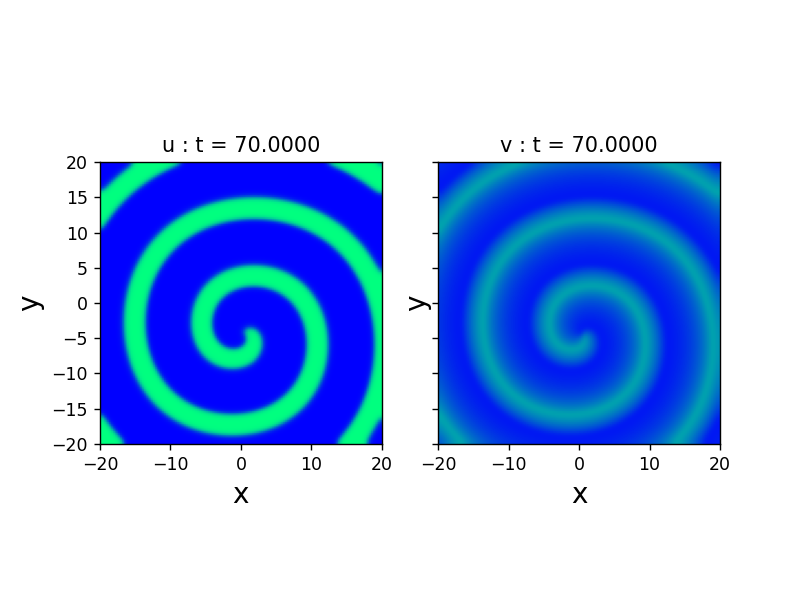

Next plots under
N=128
nout=10
a=-20.000000
b=20.000000
u.min()=  2.89928824e-10
u.max()=  9.99997080e-01
v.min()=  9.21005422e-02
v.max()=  6.42695960e-01


In [16]:
fig,ax = subplots(1,2,sharey=True)

dt = dtype([('N',int32),\
            ('nout',int32), \
            ('a',float64),\
            ('b',float64)])

fout = open("spiral_parallel.dat","rb")
N,nout,a,b = fromfile(fout,dtype=dt, count=1)[0]


dt1 = dtype([('t',float64),('u',float64,N*N),('v',float64,N*N)])
t,u,v = fromfile(fout,dtype=dt1,count=1)[0]
u = reshape(u,(N,N))
v = reshape(v,(N,N))

from matplotlib import colormaps

# Plot initial solution and store handle
extent = [a,b,a,b]

# Add title, axis labels, etc
im_u = ax[0].imshow(u.T,vmin=0,vmax=1,extent=extent,origin='lower',cmap='winter');
ax[0].set_title(f'u : t = {t:.4f}')
ax[0].set_xlabel('x',fontsize=16)
ax[0].set_ylabel('y', fontsize=16)

im_v = ax[1].imshow(v.T,vmin=0,vmax=1,extent=extent,origin='lower',cmap='winter');
ax[1].set_title(f'v : t = {t:.4f}')
ax[1].set_xlabel('x',fontsize=16)
ax[1].set_ylabel('y', fontsize=16)


print("Next plots under")
# Make axis square
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')


fig.canvas.draw() 

pause(0.1)



for i in range(nout):
    t,u,v = fromfile(fout,dtype=dt1,count=1)[0]
    u = reshape(u,(N,N))
    
    v = reshape(v,(N,N))  

    umax = u.max()
    vmax = v.max()


    im_u.set_data(u.T)
    tstr = f"u : t = {t:.4f}"
    ax[0].set_title(tstr)
    ax[0].set_aspect('equal')

    im_v.set_data(v.T)
    tstr = f"v : t = {t:.4f}"
    ax[1].set_title(tstr)
    ax[1].set_aspect('equal')
        
    fig.canvas.draw()
    
    pause(1)
    
fout.close()    

print(f"{N=:d}")
print(f"{nout=:d}")
print(f"{a=:f}")
print(f"{b=:f}")
print(f"{u.min()=:16.8e}")
print(f"{u.max()=:16.8e}")
print(f"{v.min()=:16.8e}")
print(f"{v.max()=:16.8e}")

<hr style="border:2px solid coral"></hr>

## Possible project option

<hr style="border:2px solid coral"></hr>

You may choose to do a project on one of the two problems above.  You may either choose the problem you did not do for the homework, or, you may choose a variation on one of the problems above. 

If you choose the project option, you are asked to submit results for the original problem as well as results for a "variation".  For example, there are many pattern-forming systems that can be described with a set of equations very similar to those used for the spiral waves. 

For the advection problem, you can vary the velocity field to describe simple translation in a periodic domain.  



In [17]:
%%file advect_file1.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>


double initial_condition(double x, double y)
{
    double y0 = 0.5;
    double r0 = 0.2;
    double r = fabs(y - y0);    
    if (r <= r0)
        return 0.25*(1 + cos(M_PI*r/r0));
    else
        return 0;
}

void velocity(double x, double y, double *u, double *v)
{
    *u = pow(sin(M_PI*x),2)*sin(2*M_PI*y);
    *v = -pow(sin(M_PI*y),2)*sin(2*M_PI*x);
}
double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

enum
{
    DIR_X = 0,
    DIR_Y
};

enum
{
    LEFT=0,
    RIGHT,
    BOTTOM,
    TOP
};

void comm(int N, double **u, MPI_Comm comm_cart)
{
    int nbr[4];
    double *sendbuf = allocate_1d(N,0);
    double *recvbuf = allocate_1d(N,0);
    
    int maxdims = 2;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
     int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    
     
    
   // Fill left ghost cell
    {      
       
        int tag = 0;
        int disp = 1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[N-1][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[LEFT], &nbr[RIGHT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[LEFT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[-1][j]  = recvbuf[j];       
    }     

   // Fill right ghost cell
    {    
        int tag = 1;
        
        int disp = -1;
        int dir = 0;
        for(int j = 0; j < N; j++)
            sendbuf[j] = u[0][j];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[RIGHT], &nbr[LEFT]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[LEFT], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[RIGHT], tag, 
                     comm_cart, MPI_STATUS_IGNORE);


        if (nbr[RIGHT] != MPI_PROC_NULL)
            for(int j = 0; j < N; j++)
                u[N][j]  = recvbuf[j];

    }


  // fill bottom ghost cell
    {
        int tag = 2;
        
        int disp = 1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][N-1];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[BOTTOM], &nbr[TOP]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[BOTTOM] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][-1]  = recvbuf[i];
    }

    // Fill top ghost cell
    {  
        int tag = 3;
        int disp = -1;
        int dir = 1;
        for(int i = 0; i < N; i++)
            sendbuf[i] = u[i][0];

        int ierr = MPI_Cart_shift(comm_cart, dir, disp, &nbr[TOP], &nbr[BOTTOM]);

        MPI_Sendrecv(sendbuf, N, MPI_DOUBLE, nbr[BOTTOM], tag, 
                     recvbuf, N, MPI_DOUBLE, nbr[TOP], tag, 
                     comm_cart, MPI_STATUS_IGNORE);

        if (nbr[TOP] != MPI_PROC_NULL)
            for(int i = 0; i < N; i++)
                u[i][N]  = recvbuf[i];                

    }
    free_1d(&sendbuf,0);
    free_1d(&recvbuf,0);
}
void parallel_output(MPI_Comm comm_cart, int N, int Nx, int Ny, double **q, double *qbig)
{
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int I,J;
    {
        int coords[2],ndims=2;
        MPI_Cart_coords(comm_cart,rank,ndims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
    }
    
    MPI_Comm sub_cart;
        
    // # Create a subgrid communicator.  Processors can only see those other procs that 
    // # remain in the subgrid.
    int remains[2] = {0,1}; // # Keep J in the communicator
    MPI_Cart_sub(comm_cart,remains,&sub_cart);
        
    // # Step 1 : Gather over J on each I subgrid.
    double *cols_local = (J == 0) ? allocate_1d(Nx*N,0) : NULL;
    for(int i = 0; i < Nx; i++)
        MPI_Gather(q[i],Ny,MPI_DOUBLE,&cols_local[N*i],Ny,MPI_DOUBLE,0,sub_cart); 
                
    // # Get a communicator for J=0
    MPI_Comm I_comm;
    MPI_Comm_split(MPI_COMM_WORLD,J,rank,&I_comm);
        
    // # Step 2 : Gather across I, at procs corresponding to J=0
    if (J == 0)
        MPI_Gather(cols_local,Nx*N,MPI_DOUBLE,qbig,Nx*N,MPI_DOUBLE,0,I_comm);      
    
    free_1d(&cols_local,0);
}


Overwriting advect_file1.c


In [18]:
%%file wpa1.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>
#include "advect_file1.c"

double wpa_update(int N,double dt, double h, double ** uvel, double **vvel,  
                  double** q, int order,MPI_Comm comm_cart)
{
   
    
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int maxdims = 2;
    int coords[maxdims];
    int periodicity[maxdims];
    int dims[maxdims];        
    
    MPI_Cart_get(comm_cart,maxdims,dims,periodicity,coords);
    int I = coords[DIR_X];    
    int Imax = dims[DIR_X];
    
    int J = coords[DIR_Y];    
    int Jmax = dims[DIR_Y];
  
    
    
    double **apdq = allocate_2d(N+1,N,0);
    double **amdq = allocate_2d(N+1,N,0);

    double **bpdq = allocate_2d(N,N+1,0);
    double **bmdq = allocate_2d(N,N+1,0);
    
    int nbr[4];
    
    comm(N, q, comm_cart);  
    
    // # X-sweep
    double uvmax = 0;
    for(int i = 0; i < N+1; i++)
        for(int j = 0; j < N; j++)
        {
           
            double wave = q[i][j] - q[i-1][j];
            double u = uvel[i][j];
            apdq[i][j] = fmax(u,0)*wave;
            amdq[i][j] = fmin(u,0)*wave;
            
            if (order == 2)
            {
                double cxx = 0.5*fabs(u)*(1 - dt*fabs(u)/h);
                apdq[i][j] -= cxx*wave;
                amdq[i][j] += cxx*wave;
            }
            uvmax = fmax(uvmax,fabs(u));
        }

    // # Y-sweep
    for(int i = 0; i < N; i++)
        for(int j = 0; j < N+1; j++)
        {
            double wave = q[i][j] - q[i][j-1];
            double v = vvel[i][j];
            bpdq[i][j] = fmax(v,0)*wave;
            bmdq[i][j] = fmin(v,0)*wave;
            
            if (order == 2)
            {
                double cyy = 0.5*fabs(v)*(1 - dt*fabs(v)/h);
                bpdq[i][j] -= cyy*wave;
                bmdq[i][j] += cyy*wave;
            }
            uvmax = fmax(uvmax,fabs(v));
        }
     
    for(int i = 0; i < N; i++)
        for (int j = 0; j < N; j++)
            {
                q[i][j] -= dt/h*(apdq[i][j] + amdq[i+1][j] + bpdq[i][j] + bmdq[i][j+1]); 
            }
    
    free_2d(&apdq,0);
    free_2d(&amdq,0);
    free_2d(&bpdq,0);
    free_2d(&bmdq,0);
    
    double cflmax = dt*uvmax/h;
    return cflmax;
}

Overwriting wpa1.c


In [19]:
%%file advert_parallel.c
#include "wpa1.c"

int main(int argc, char** argv)
{
    FILE* fout = fopen("advect_parallel.dat","wb"); 
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    
    // #Timing
    double time_start, time_elapsed;
    int root = 0;
    int N;
    int ndim = 2;
    int dims[ndim];
    

    // # Number of processors in each direction.  Product should equal nprocs.
    dims[DIR_X] = atoi(argv[1]);
    dims[DIR_Y] = atoi(argv[2]);
        

    

    N = atoi(argv[3]);    
   

    if (rank == root)
        if (dims[DIR_X]*dims[DIR_Y] !=nprocs)
        {
            printf("dim[0]*dim[1] != nprocs\n");
            exit(0);
        }

    // # Domain
   
    double a = 0, b = 1;
    double Tfinal = 2;
    
    // # Numerical parameters
    int method_order = 2; 
    int prt = 0;
   
    MPI_Comm comm_cart;
    int periodicity[2] = {0,0};
    int reorder = 0;
    MPI_Cart_create(MPI_COMM_WORLD, ndim, dims,  periodicity, reorder, &comm_cart);

    // # Get coordinate of current rank
    int I, J, coords[ndim];
    {
        int maxdims = 2;
        MPI_Cart_coords(comm_cart,rank,maxdims,coords);
        I = coords[DIR_X];
        J = coords[DIR_Y];
        
    }
       
   
    int P = nprocs;
   
    // # Set grid values
       
    // Assume Nx = Ny
    int Nx = N/dims[DIR_X];
    
    double dw = (b-a)/dims[DIR_X];
    double a_local_x = a + I*dw;
       
    double a_local_y = a + J*dw;

    double h = (b - a)/N;
            
    
    int N_local = Nx;
   
    int Imax = dims[DIR_X];
    int Jmax = dims[DIR_Y];
    
    // # Arrays - Use cell centered mesh
    double **q_local = allocate_2d(N_local,N_local,1);
    double **uvel_local = allocate_2d(N_local+1,N_local,0);
    double **vvel_local = allocate_2d(N_local,N_local+1,0);
    
    
    // # Edges (xe) and centers (xc)
    double *xe_local = allocate_1d(N_local+1,1);
    double *xc_local = allocate_1d(N_local,1);
    double *ye_local = allocate_1d(N_local+1,1);
    double *yc_local = allocate_1d(N_local,1);

    time_start = MPI_Wtime();  
    
    for(int i = -1; i < N_local+1; i++)
    {
        xe_local[i] = a_local_x + i*h;
        xc_local[i] = a_local_x+ (i+0.5)*h;
    }
    xe_local[N_local+1] = a_local_x + (N_local+1)*h;
    
    for(int i = -1; i < N_local+1; i++)
    {
        ye_local[i] = a_local_y + i*h;
        yc_local[i] = a_local_y+ (i+0.5)*h;
    }
    ye_local[N_local+1] =a_local_y + (N_local+1)*h;

    
    for(int i = -1; i < N_local+1; i++)
        for(int j = -1; j < N_local+1; j++)   // # initialize ghost cells
            q_local[i][j] = initial_condition(xc_local[i],yc_local[j]);
    
    // # Get u velocities at centes of edges of x faces
    double vvelx_local; // # not used at x-face
    for(int i = 0; i < N_local+1; i++)
        for(int j = 0; j < N_local; j++)            
            velocity(xe_local[i],yc_local[j],&uvel_local[i][j],&vvelx_local);
    
    
    // # Get v velocities at centesr of edges of y faces
    double uvely_local; // # not used at x-face
    for(int i = 0; i < N_local; i++)
        for(int j = 0; j < N_local+1; j++)            
            velocity(xc_local[i],ye_local[j],&uvely_local,&vvel_local[i][j]);
    
    // #TIME LOOP
    
    // # Compute a time step
    double cfl = 0.45;
    double uvmax = 1;
    double dt_est = cfl*h/uvmax;
    int M = ceil(Tfinal/dt_est) + 1;
    double dt = Tfinal/M;
    double t = 0;
    
    double *qbig = NULL;
    if (rank == 0)
    {     
    fwrite(&N,sizeof(int),1,fout);    
    fwrite(&M,sizeof(int),1,fout);
    fwrite(&method_order,sizeof(int),1,fout);
    fwrite(&a,sizeof(double),1,fout);
    fwrite(&b,sizeof(double),1,fout);
    fwrite(&dt,sizeof(double),1,fout);
    
    // # write out initial condition
    
    fwrite(&t,sizeof(double),1,fout);
    qbig  = allocate_1d(N*N,0); 
    }
    
    // # Use parallel output routine above to gather solution to qbig on rank 0
    parallel_output(comm_cart,N,N_local,N_local,q_local,qbig);
    
    // # Write out the big array
    if (rank == 0)
    {
        fwrite(qbig,sizeof(double),N*N,fout);                         
        free_1d(&qbig,0);        
    }
    

    
    for(int n = 0; n <M; n++)
    {
        
        // # Update solution
        double cflmax = wpa_update(N_local, dt, h, uvel_local, vvel_local,  q_local, method_order,comm_cart);
        
        double MAXCFL;
        MPI_Reduce(&cflmax, &MAXCFL, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD); 
        
        if (rank == 0)
        {
          if (prt)
            printf("%12.4f %8.4f\n",t,MAXCFL);
        
            t += dt;
            fwrite(&t,sizeof(double),1,fout);
            qbig  = allocate_1d(N*N,0);
        }
        parallel_output(comm_cart,N,N_local,N_local,q_local,qbig);
        
        if (rank == 0)
        {
            fwrite(qbig,sizeof(double),N*N,fout);                         
            free_1d(&qbig,0);        
        }

        
    }
 
    fclose(fout);
    
    time_elapsed = MPI_Wtime() - time_start;

     if(rank==0) printf(" %d,  %d, %fs\n",nprocs,N,time_elapsed);
    
    free_2d(&q_local,1);
    free_2d(&uvel_local,0);
    free_2d(&vvel_local,0);
    free_1d(&xe_local,1);
    free_1d(&xc_local,1);
    free_1d(&ye_local,1);
    free_1d(&yc_local,1);
    
    MPI_Finalize();
    return 0;
}

Overwriting advert_parallel.c


In [20]:
%%bash 

rm -rf advect_parallel.dat
mpicc -o advert_parallel advert_parallel.c

# mpirun -n <nprocs> cart_03 <dim[0]> <dim[1]>
# where dim[0]*dim[1] = nprocs

mpirun -n 4 ./advert_parallel  2 2 64

 4,  64, 0.058131s


In [21]:
import os

fout = open("advect_parallel.dat","rb")
N,M, = fromfile(fout,dtype=int32,count=2)
fout.close()

stats = os.stat("advect_parallel.dat")
print(f"File size          : {stats.st_size:d} bytes ({stats.st_size/1024:.2f} kB)")

esize = 3*4 + 8*(3 + (M+1)*(N**2+1))
print(f"Expected file size : {esize:d} bytes")

File size          : 9406748 bytes (9186.28 kB)
Expected file size : 9406748 bytes


<IPython.core.display.Javascript object>


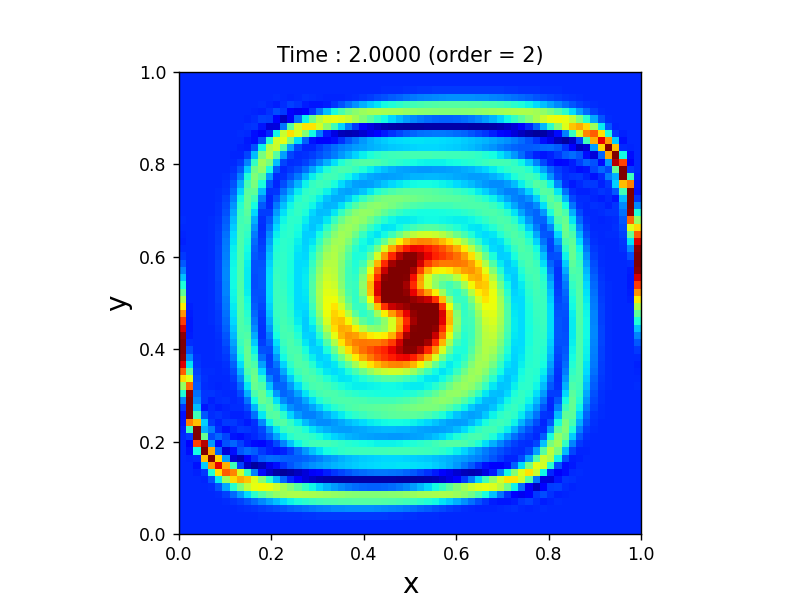

N=64 M=286 dt_step=0.0069930069930070
qmax=6.2669938676423842e-01 qmin=-8.4709467794999646e-02


In [22]:
fig = figure(5)
clf()

set_cmap('jet')


dt = dtype([('N',int32),\
            ('M',int32), \
            ('order',int32), \
            ('a',float64),\
            ('b',float64),
            ('dt',float64)])

fout = open("advect_parallel.dat","rb")
N,M,method_order,a,b,dt_step = fromfile(fout,dtype=dt, count=1)[0]

dt1 = dtype([('t',float64),('q',float64,N*N)])
t,q = fromfile(fout,dtype=dt1,count=1)[0]
q = reshape(q,(N,N))


# Plot initial solution and store handle
extent = [a,b,a,b]
im = imshow(q.T,vmin=-0.1,vmax=0.5,extent=extent,origin='lower');

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0))
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

# Make axis square
gca().set_aspect(1)

fig.canvas.draw() 

pause(0.1)

for i in range(M):
    t,q = fromfile(fout,dtype=dt1,count=1)[0]
    
    q = reshape(q,(N,N))

    im.set_data(q.T)
    
    # Update title with new time
    htitle.set_text('Time : {:.4f} (order = {:d})'.format(t,method_order))
    
    # Make axis square
    gca().set_aspect(1)
    
    fig.canvas.draw()
    
    pause(0.1)
    
fout.close()    



print(f"{N=:d} {M=:d} {dt_step=:.16f}")
qmax = q.max()
qmin = q.min()
print(f"{qmax=:20.16e} {qmin=:20.16e}")

## EXTRA CREDITS

I conducted a series of strong scaling runs for the advection problem in Borah. I created a run_script that submitted the job and recorded the time from the log file. I struggled to get it to work because I was using Borah for the first time. My script would only send one job at a time, and I would have to manually change the number of processors after every run, which is quite tedious.

A sample run_script is shown below:

In [23]:
'''
#!/bin/bash
#SBATCH -J advection # job name
#SBATCH -o log_slurm.o%j # output and error file name (%j expands to jobID)
#SBATCH -n 64 # total number of tasks requested
#SBATCH -N 2 # number of nodes you want to run on
#SBATCH -p short # queue (partition)
#SBATCH -t 00:40:00 # run time (hh:mm:ss) - 12.0 hours in this example

mpirun -n 49 ./advert_parallel  7 7 1024

'''


'\n#!/bin/bash\n#SBATCH -J advection # job name\n#SBATCH -o log_slurm.o%j # output and error file name (%j expands to jobID)\n#SBATCH -n 64 # total number of tasks requested\n#SBATCH -N 2 # number of nodes you want to run on\n#SBATCH -p short # queue (partition)\n#SBATCH -t 00:40:00 # run time (hh:mm:ss) - 12.0 hours in this example\n\nmpirun -n 49 ./advert_parallel  7 7 1024\n\n'

In [24]:
N = 1024 #problem size
nprocs = np.array([1,4,9,16,25,36,49]) # Number of processors
time = np.array([313.034365,112.41543,79.590985,71.709946,67.120307,77.27624,111.907454]) # Time in secs

In [25]:
speed_up = time[0]/time

<IPython.core.display.Javascript object>


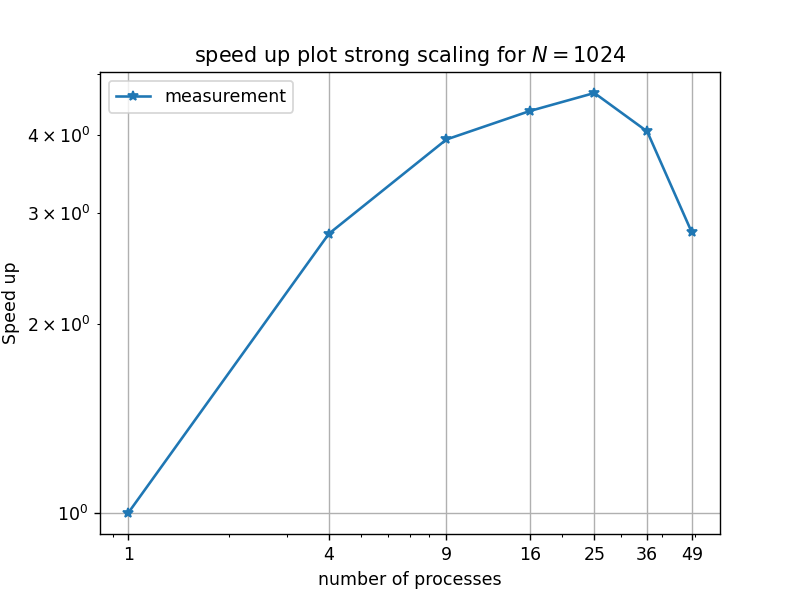

In [26]:
figure(6)
clf()
loglog(nprocs,speed_up,"-*",label='measurement')
ylabel("Speed up")
grid()
xlabel("number of processes")
title("speed up plot strong scaling for $N=1024$")
legend()

pstr = ([f'{p}' for p in nprocs])
xticks(nprocs,pstr)
show()

From the figure above, it can be observed that the measured speed-up increases until when the number of processors = 25, and then it begins to decrease. This occurrence could be attributed to overheads or load imbalance. 

In [27]:


#efficiency plot
eff = speed_up/nprocs

In [28]:
ideal = ones_like(eff)

<IPython.core.display.Javascript object>


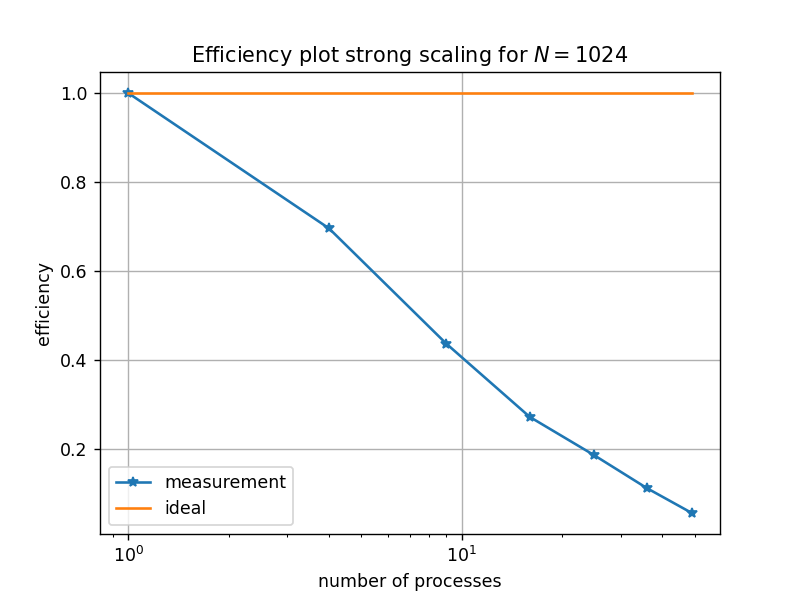

In [29]:
figure(7)
clf()

semilogx(nprocs,eff,"-*",label='measurement')
semilogx(nprocs,ideal,label='ideal')
title("Efficiency plot strong scaling for $N=1024$")
ylabel("efficiency")
xlabel("number of processes")
grid()
legend()
show()

It can be observed that the efficiency of the strong scaling experiment decreases as we increase the number of processors.